In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("three_way.csv")
df.head()

,id,gender,risk,treatment,pain_score
0,1,male,low,X,79.311695
1,2,male,low,X,76.843399
2,3,male,low,X,70.832421
3,4,male,low,X,81.163944
4,5,male,low,X,75.052213


## Summary Statistics

In [3]:
stats = df.groupby(['gender', 'risk', 'treatment'])['pain_score'].agg(['count', 'std', 'mean'])
stats

count       std       mean
gender risk treatment                            
female high X              6  5.316489  78.865059
            Y              6  4.619387  81.175304
            Z              6  3.984886  81.035142
       low  X              6  3.690272  74.156231
            Y              6  4.081842  68.361925
            Z              6  2.719645  69.779555
male   high X              6  5.116095  92.738847
            Y              6  5.000898  82.341542
            Z              6  4.045885  79.680736
       low  X              6  3.854876  76.051783
            Y              6  4.765061  73.138772
            Z              6  4.888865  74.455863

## Catplot

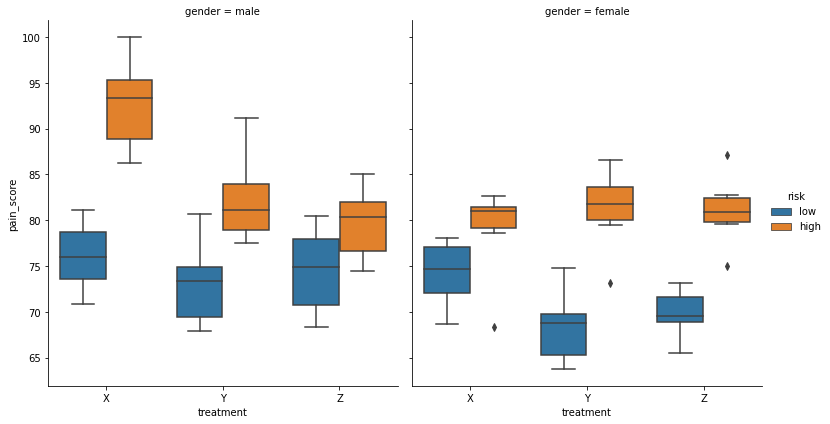

In [4]:
sns.catplot(x="treatment", y="pain_score",
                hue="risk", col="gender",
                data=df, kind="box",
                height=6, aspect=.9);

## Interaction plot using Seaborn

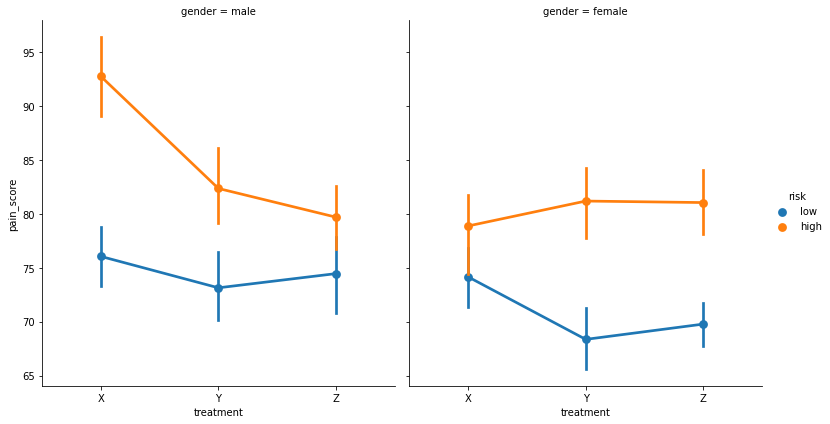

In [5]:
sns.catplot(x="treatment", y="pain_score",
                hue="risk", col="gender",
                data=df, kind="point",
                height=6, aspect=.9);

# Assumptions

### Outliers

In [6]:
def outliers(dep, ind1, ind2, ind3):
    dicts = {'Outliers':{}}
    for cat_ind1 in pd.unique(df[ind1]):
        for cat_ind2 in pd.unique(df[ind2]):
            for cat_ind3 in pd.unique(df[ind3]):
                Q1, Q3 = np.percentile(df[dep][df[ind1] == cat_ind1][df[ind2] == cat_ind2][df[ind3] == cat_ind3], [25,75])
                IQR = Q3-Q1
                lower_fence, upper_fence= Q1-(1.5*IQR), Q3+(1.5*IQR)
                new_dataset = []
                for i in df[dep][df[ind1] == cat_ind1][df[ind2] == cat_ind2][df[ind3] == cat_ind3]:
                    if i < lower_fence or i > upper_fence:
                        new_dataset.append(i)
                dicts['Outliers'][f'{cat_ind1}, {cat_ind2} and {cat_ind3}'] = new_dataset
    return pd.DataFrame(dicts)

In [7]:
outliers('pain_score', 'gender', 'risk', 'treatment')

,Outliers
"female, high and X",[68.3601845243011]
"female, high and Y",[73.14439241953]
"female, high and Z","[74.988057290167, 87.1422645214203]"
"female, low and X",[]
"female, low and Y",[]
"female, low and Z",[]
"male, high and X",[]
"male, high and Y",[]
"male, high and Z",[]
"male, low and X",[]


### Normality

In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
mod = ols('pain_score ~ gender*risk*treatment', data=df).fit()

C:\ProgramData\Anaconda3\envs\All\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [9]:
import scipy.stats as stats
stats.shapiro(mod.resid)

ShapiroResult(statistic=0.9821221232414246, pvalue=0.3980903923511505)

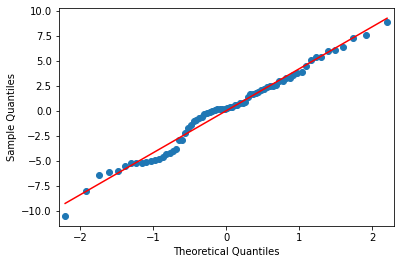

In [10]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import pylab
sm.qqplot(mod.resid, line='r')
pylab.show()

#### Shapiro

In [11]:
def shapiro(dep, ind1, ind2, ind3):
    normality = {'Shapiro':{}}
    import scipy.stats as stats
    for cat_ind1 in pd.unique(df[ind1]):
        for cat_ind2 in pd.unique(df[ind2]):
            for cat_ind3 in pd.unique(df[ind3]):
                result = stats.shapiro(df[dep][df[ind1] == cat_ind1][df[ind2] == cat_ind2][df[ind3] == cat_ind3])
                normality['Shapiro'][f'{cat_ind1}, {cat_ind2} and {cat_ind3}'] = result
    return pd.DataFrame(normality)

In [12]:
shapiro('pain_score', 'gender', 'risk', 'treatment')

,Shapiro
"female, high and X","(0.7141793966293335, 0.008690106682479382)"
"female, high and Y","(0.9393326044082642, 0.6538262367248535)"
"female, high and Z","(0.9712316393852234, 0.9006036520004272)"
"female, low and X","(0.9325503706932068, 0.5999364256858826)"
"female, low and Y","(0.9267739653587341, 0.5554291009902954)"
"female, low and Z","(0.957584798336029, 0.8009467720985413)"
"male, high and X","(0.9584341049194336, 0.8075945973396301)"
"male, high and Y","(0.901729941368103, 0.3842567503452301)"
"male, high and Z","(0.9554784297943115, 0.784304141998291)"
"male, low and X","(0.982193648815155, 0.9619279503822327)"


### Homogneity of variance

In [13]:
# if normality exists then perform bartlett otherwise levene's tests

In [14]:
# Null Hypothesis: the variances are equal across all samples/groups
# Alternative Hypothesis:  the variances are not equal across all samples/groups

In [15]:
def homogeneity(dep, ind1, ind2, ind3):
    combinations = []
    homo = {'Bartlett':{}, 'Levene':{}}

    for cat_ind1 in pd.unique(df[ind1]):
        for cat_ind2 in pd.unique(df[ind2]):
            for cat_ind3 in pd.unique(df[ind3]):
                result = df[dep][df[ind1] == cat_ind1][df[ind2] == cat_ind2][df[ind3] == cat_ind3]
                combinations.append(result)
    from scipy.stats import bartlett
    import scipy.stats as stats
    stat, p = bartlett(combinations[0], combinations[1], combinations[2], combinations[3], combinations[4], combinations[5],
                       combinations[6], combinations[7], combinations[8], combinations[9], combinations[10], combinations[11])
    bstat, bp = stat, p
    from scipy.stats import levene
    stat, p = levene(combinations[0], combinations[1], combinations[2], combinations[3], combinations[4], combinations[5],
                     combinations[6], combinations[7], combinations[8], combinations[9], combinations[10], combinations[11])
    lstat, lp = stat, p

    homo['Bartlett']['stat'] = bstat
    homo['Bartlett']['p-value'] = bp
    homo['Levene']['stat'] = lstat
    homo['Levene']['p-value'] = lp
    
    return pd.DataFrame(homo)

In [16]:
homogeneity('pain_score', 'gender', 'risk', 'treatment')

,Bartlett,Levene
stat,3.189160,0.178595
p-value,0.987982,0.998214


## Three-Way ANOVA Computation

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('pain_score ~ gender*risk*treatment', data=df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
gender,313.358773,1.0,16.195746,1.625409e-04
risk,1793.555757,1.0,92.698774,8.799980e-14
treatment,283.168031,2.0,7.317679,1.432844e-03
gender:risk,2.730584,1.0,0.141128,7.084867e-01
gender:treatment,129.182324,2.0,3.338353,4.220011e-02
risk:treatment,27.595016,2.0,0.713115,4.942214e-01
gender:risk:treatment,286.595625,2.0,7.406255,1.334476e-03
Residual,1160.892871,60.0,NaN,NaN


## Post-hoct tests

### Procedure for significant two-way interaction

#### Simple two-way interaction

In [18]:
# run two-way interaction at each level of third variable

In [19]:
male = df[df['gender'] == 'male']
female = df[df['gender'] == 'female']

dataframes = [male, female]
names = ['male', 'female']

for i, j in zip(dataframes, names):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    ols = ols('pain_score ~ risk*treatment', data=i).fit()           
    table = sm.stats.anova_lm(ols, typ=2)
    print(f'\n{j}\n', table)


male
                     sum_sq    df          F        PR(>F)
risk            968.124984   1.0  45.022276  1.954190e-07
treatment       393.710706   2.0   9.154682  7.876787e-04
risk:treatment  203.220142   2.0   4.725337  1.644381e-02
Residual        645.097320  30.0        NaN           NaN

female
                     sum_sq    df          F        PR(>F)
risk            828.161356   1.0  48.168001  1.042751e-07
treatment        18.639649   2.0   0.542065  5.871351e-01
risk:treatment  110.970499   2.0   3.227165  5.377519e-02
Residual        515.795551  30.0        NaN           NaN


##### Simple main effect

In [20]:
# run one-way model at each level of second variable.
# Group the data by gender and risk and analyze the simple simple main effects of treatment on pain_score:

In [21]:
high_male = df[df['risk'] == 'high'][df['gender'] == 'male']
low_male = df[df['risk'] == 'low'][df['gender'] == 'male']

dataframes = [high_male, low_male]
names = ['high_male', 'low_male']

for i, j in zip(dataframes, names):
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    ols = ols('pain_score ~ treatment', data=i).fit()
    table = sm.stats.anova_lm(ols, typ=2)
    print(f'\n{j}:\n', table)


high_male:
                sum_sq    df          F    PR(>F)
treatment  571.396212   2.0  12.687808  0.000595
Residual   337.762949  15.0        NaN       NaN

low_male:
                sum_sq    df         F    PR(>F)
treatment   25.534637   2.0  0.623132  0.549583
Residual   307.334371  15.0       NaN       NaN


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5172\1210033639.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_male = df[df['risk'] == 'high'][df['gender'] == 'male']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5172\1210033639.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  low_male = df[df['risk'] == 'low'][df['gender'] == 'male']


##### Simple pairwise comparisons:

In [22]:
# run pairwise or other post-hoc comparisons if necessary.
# A statistically significant simple simple main effect can be followed up by multiple pairwise comparisons to determine which group means are different.
# Compare the different treatments by gender and risk variables:

In [23]:
high_male = df[df['risk'] == 'high'][df['gender'] == 'male']
low_male = df[df['risk'] == 'low'][df['gender'] == 'male']
high_female = df[df['risk'] == 'high'][df['gender'] == 'female']
low_female = df[df['risk'] == 'low'][df['gender'] == 'female']

dataframes = [high_male, low_male, high_female, low_female]
names = ['high_male', 'low_male', 'high_female', 'low_female']

for i, j in zip(dataframes, names):
    import pingouin as pg
    ptest = pg.pairwise_ttests(dv='pain_score', between=['treatment'], padjust='bonf', data=i)
    print(f'\n{j}:\n\n', ptest)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5172\593856769.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_male = df[df['risk'] == 'high'][df['gender'] == 'male']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5172\593856769.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  low_male = df[df['risk'] == 'low'][df['gender'] == 'male']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5172\593856769.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_female = df[df['risk'] == 'high'][df['gender'] == 'female']
C:\Users\Administrator\AppData\Local\Temp\ipykernel_5172\593856769.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  low_female = df[df['risk'] == 'low'][df['gender'] == 'female']



high_male:

     Contrast  A  B  Paired  Parametric         T   dof alternative     p-unc  \
0  treatment  X  Y   False        True  3.559851  10.0   two-sided  0.005183   
1  treatment  X  Z   False        True  4.903869  10.0   two-sided  0.000620   
2  treatment  Y  Z   False        True  1.013219  10.0   two-sided  0.334843   

     p-corr p-adjust    BF10    hedges  
0  0.015548     bonf   8.291  1.897182  
1  0.001859     bonf  40.866  2.613461  
2  1.000000     bonf   0.644  0.539983  

low_male:

     Contrast  A  B  Paired  Parametric         T   dof alternative     p-unc  \
0  treatment  X  Y   False        True  1.164182  10.0   two-sided  0.271373   
1  treatment  X  Z   False        True  0.627898  10.0   two-sided  0.544143   
2  treatment  Y  Z   False        True -0.472570  10.0   two-sided  0.646664   

     p-corr p-adjust   BF10    hedges  
0  0.814119     bonf   0.71  0.620438  
1  1.000000     bonf   0.53  0.334631  
2  1.000000     bonf  0.502 -0.251851  

high_f

# Report

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

X_high vs. Y_high: Custom statistical test, P_val:1.554e-02
Y_high vs. Z_high: Custom statistical test, P_val:1.000e+00
X_low vs. Y_low: Custom statistical test, P_val:8.140e-01
Y_low vs. Z_low: Custom statistical test, P_val:1.000e+00
X_high vs. Z_high: Custom statistical test, P_val:1.850e-03
X_low vs. Z_low: Custom statistical test, P_val:1.000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

X_high vs. Y_high: Custom statistical test, P_val:1.000e+00
Y_high vs. Z_high: Custom statistical test, P_val:1.000e+00
X_low vs. Y_low: Custom statistical test, P_val:8.230e-02
Y_low vs. Z_low: Custom statistical test, P_val:1.000e+00
X_high vs. Z_high: Custom statistical test, P_va

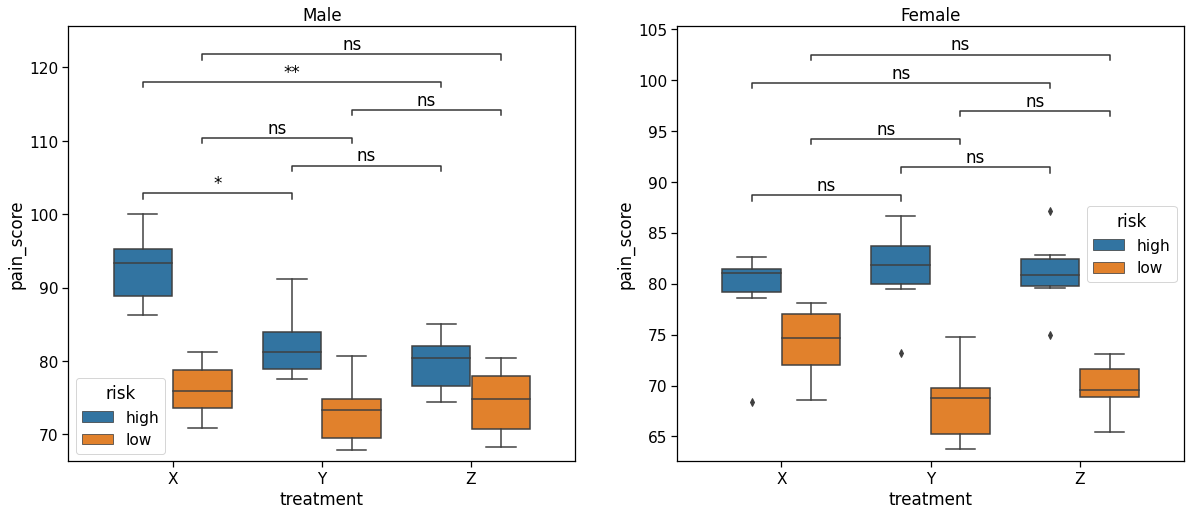

In [24]:
from statannotations.Annotator import Annotator

# palette = sns.color_palette("YlGnBu", n_colors=3)

hue_order = ["high", "low"]
subcat_order = ['X', 'Y', 'Z']

male_pvalues = [0.01554, 0.00185, 1, 0.814, 1, 1]
female_pvalues = [1, 1, 1, 0.0823, 0.12431, 1]

# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls..
male_pairs = [
    [('X', 'high'), ('Y', 'high')],
    [('X', 'high'), ('Z', 'high')],
    [('Y', 'high'), ('Z', 'high')],
    
    [('X', 'low'), ('Y', 'low')],
    [('X', 'low'), ('Z', 'low')],
    [('Y', 'low'), ('Z', 'low')],
]

female_pairs = [
    [('X', 'high'), ('Y', 'high')],
    [('X', 'high'), ('Z', 'high')],
    [('Y', 'high'), ('Z', 'high')],
    
    [('X', 'low'), ('Y', 'low')],
    [('X', 'low'), ('Z', 'low')],
    [('Y', 'low'), ('Z', 'low')],
]

male_df = df[df['gender']=='male']
female_df = df[df['gender']=='female']

male_plotting_parameters = {
    'data':male_df,
    'x': 'treatment',
    'y': 'pain_score',
    "order": subcat_order,
    "hue": 'risk',
    "hue_order": hue_order,
#     "palette": palette,
}

female_plotting_parameters = {
    'data':female_df,
    'x': 'treatment',
    'y': 'pain_score',
    "order": subcat_order,
    "hue": 'risk',
    "hue_order": hue_order,
#     "palette": palette,
}

with sns.plotting_context('notebook', font_scale = 1.4):
    from matplotlib import pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    ax1 = sns.boxplot(**male_plotting_parameters, ax=ax1)
    ax1.set_title("Male")
    
    ax2 = sns.boxplot(**female_plotting_parameters, ax=ax2)
    ax2.set_title("Female")

    # Add annotations
    annotator = Annotator(ax1, male_pairs, **male_plotting_parameters)
    annotator.set_pvalues(male_pvalues)
    annotator.annotate()

    annotator = Annotator(ax2, female_pairs, **female_plotting_parameters)
    annotator.set_pvalues(female_pvalues)
    annotator.annotate()
    
    plt.show()